In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
import functools
from matplotlib import pyplot as plt
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

from gantools import utils, plot, data, evaluation, blocks
from gantools.gansystem import GANsystem, UpcaleGANsystem
from gantools.model import WGAN, UpscalePatchWGAN, CosmoWGAN



Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# Setting the forward and backward transform

# forward = data.fmap.log_forward
# backward = data.fmap.log_backward

forward = data.fmap.stat_forward
backward = data.fmap.stat_backward


# number of sample generated
num_samples = 30

pathmodel = '../saved_results/nbody'
pathsample = '../samples/nbody'

In [4]:
def plot_cubes_paper(cubes, slice_num=None, nx=2, ny=2, bkd=backward, **kwargs):
    def map_to_plot(img):
        return data.fmap.log_forward(bkd(img))
    if len(cubes)<nx*ny:
        raise ValueError("Not enough samples.")
    if slice_num is None:
        slice_num = cubes.shape[1]//2+4
    fig, ax = plt.subplots(nx, ny, sharey=True,figsize=(11/2*nx,10.5/2*ny))
    sn = 0
    for i in range(nx):
        for j in range(ny):
            if nx==1 and ny==1:
                tax = ax
            elif nx==1:
                tax = ax[j]
            elif ny==1:
                tax = ax[i]
            else:
                tax = ax[i,j]
            tax.imshow(map_to_plot(cubes[sn,slice_num]), interpolation='none', **kwargs)
            tax.axis('off')
            sn += 1
    plt.tight_layout()

    return fig

# Generate samples - 32->64->256

## 0->32

In [5]:
name = 'WGAN_stat-0_to_32_checkpoints'
checkpoint32 = 55000

pathmodel32 = os.path.join(pathmodel, name)
params_32 = utils.load_params(pathmodel32)
# params_32 = old2new_params(params_32, CosmoWGAN)
# params_32['net']['shape'] = [*params_32['net']['shape'],1]

# params_32['net']['cosmology']['backward_map'] = backward
# params_32['net']['cosmology']['forward_map'] = forward
# params_32['summary_dir'] = os.path.join(pathmodel, name +'summary/')

# for ind, item in enumerate(params.items()):
#     print(ind, " : ", item[0], " - ", item[1])
# print(resume)


In [6]:
wgan_32 = GANsystem(CosmoWGAN,params_32)

Generator 
--------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 4, 4, 4, 512)
     1 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 8, 8, 8, 256)
     2 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 16, 128)
     3 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     4 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 32, 64)
     5 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 32, 1)
     The output is of size (?, 32, 32, 32, 1)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input is of size (?, 32, 32, 32, 1)
Warning spec

In [7]:
gen_samples_32 = wgan_32.generate(N=num_samples, checkpoint=checkpoint32)
gen_samples_32 = np.squeeze(gen_samples_32)

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/nbody/WGAN_stat-0_to_32_checkpoints/wgan-55000
Checkpoint succesfully loaded!


In [8]:
os.makedirs(os.path.join(pathsample,'stat-0_32/'), exist_ok=True)
utils.save_hdf5(gen_samples_32, os.path.join(pathsample,'stat-0_32/32_samples_ckpt_latest.h5'))

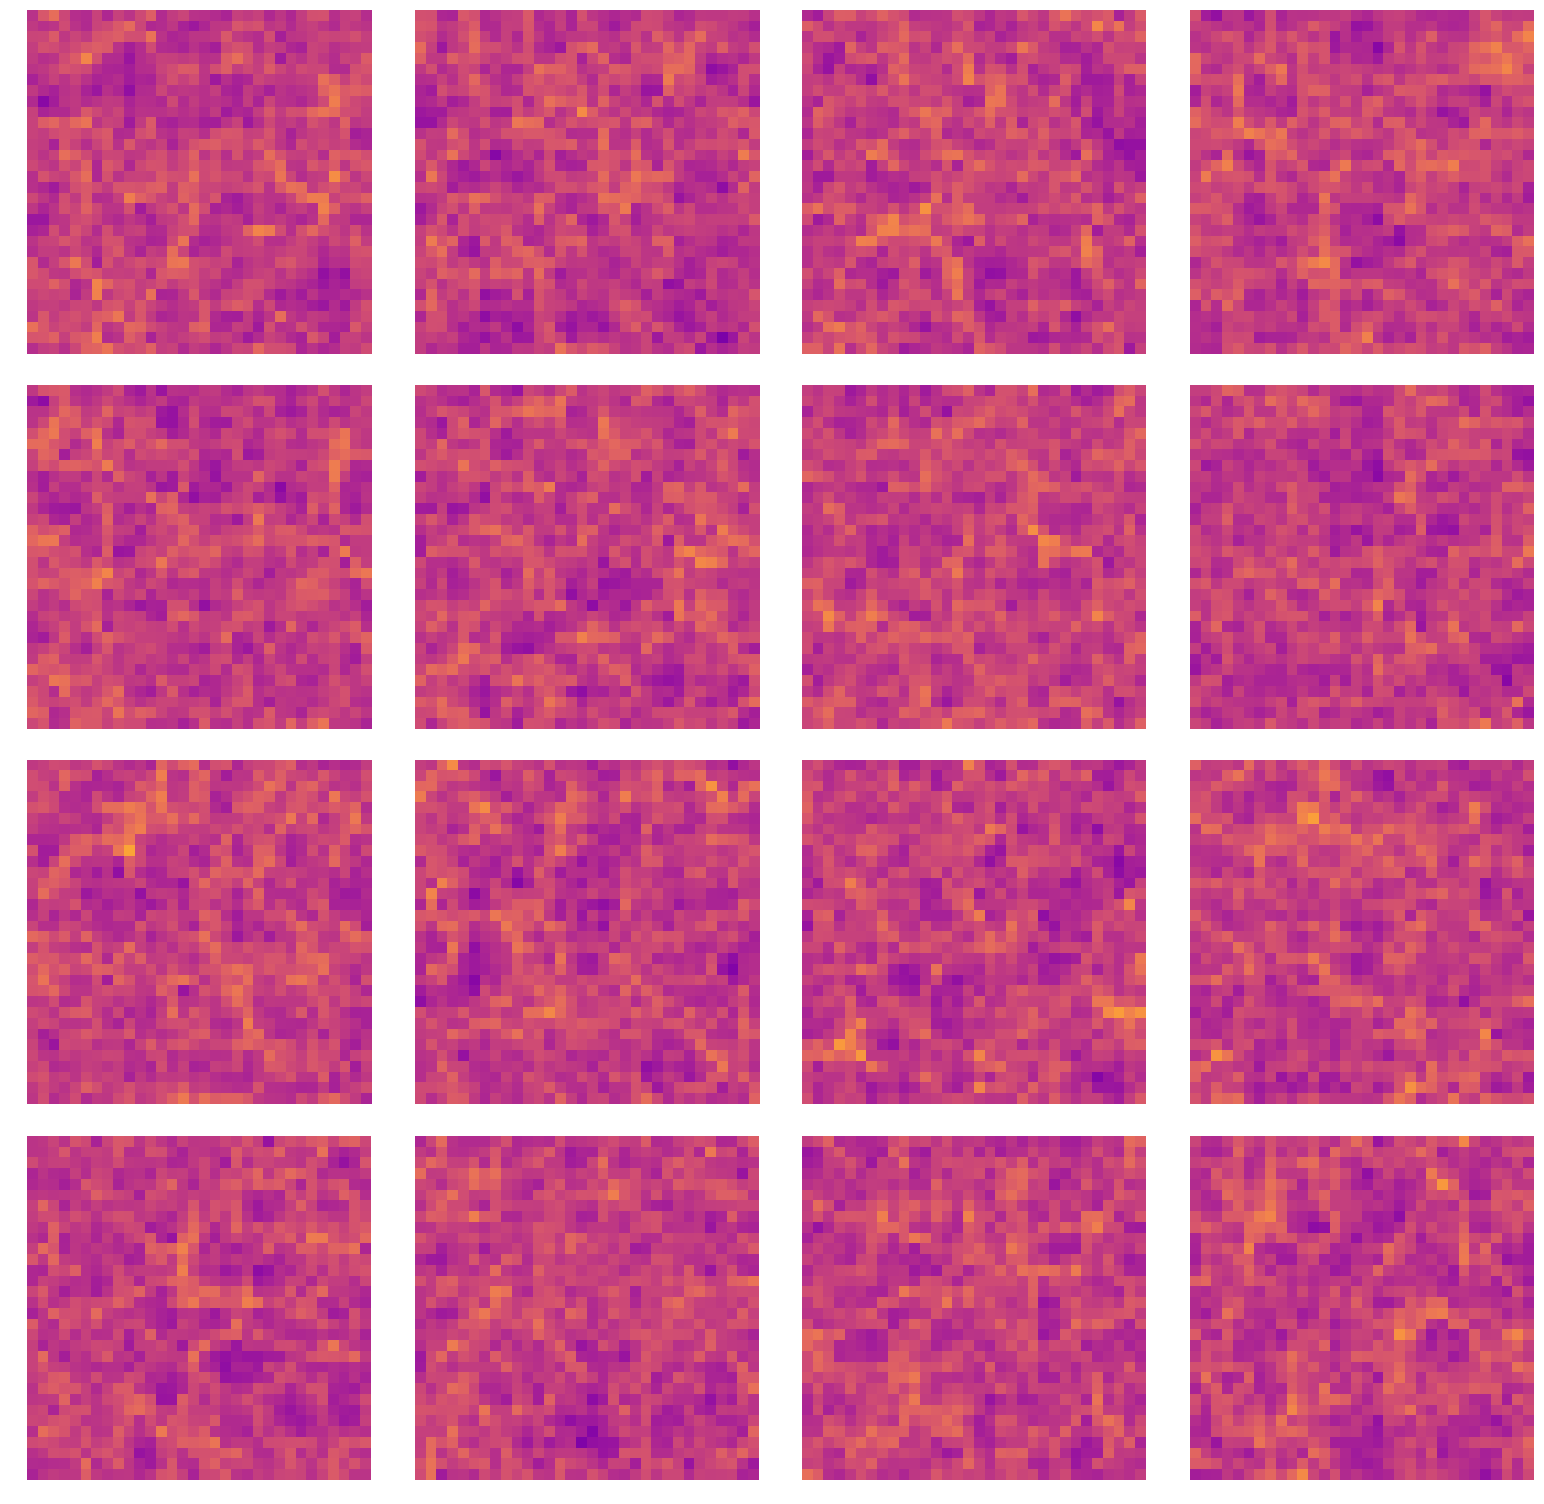

In [9]:
cmin = 0.1
cmax = 2
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);

## 32->64

Load fake 32

In [10]:
gen_samples_32 = utils.load_hdf5(os.path.join(pathsample,'stat-0_32/32_samples_ckpt_latest.h5'))[:num_samples]
print("gen_samples_32 shape=", gen_samples_32.shape)
gen_samples_32 = np.expand_dims(gen_samples_32, axis=4)
print('downsampled shape=', gen_samples_32.shape)

gen_samples_32 shape= (30, 32, 32, 32)
downsampled shape= (30, 32, 32, 32, 1)


In [11]:
name = 'WGAN_stat-32_to_64_checkpoints'
checkpoint64 = 70000
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass

pathmodel64 = os.path.join(pathmodel, name)
params_64 = utils.load_params(pathmodel64)
# params_64['net']['generator']['use_old_gen'] = True

In [12]:
wgan_64 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_64)
gen_samples_64 = wgan_64.upscale_image(small=gen_samples_32, checkpoint=checkpoint64)

Using X_down instead of X_smooth
Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 32, 32, 32, 7)
     BORDER: 0 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 16, 64)
     BORDER: 1 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 8, 64)
     BORDER: 2 Conv layer with 16 channels
         BORDER:  Size of the conv variables: (?, 4, 4, 4, 16)
     BORDER:  Size of the conv variables: (?, 1024)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 1280)
     0 Full layer with 16384 outputs
         Size of the variables: (?, 16384)
     Reshape to (?, 16, 16, 16, 4)
     Contenate with latent variables to (?, 16, 16, 16, 5)
     1 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?

In [13]:
os.makedirs(os.path.join(pathsample,'stat-32_64/'), exist_ok=True)
utils.save_hdf5(gen_samples_64, os.path.join(pathsample,'stat-32_64/64_samples_ckpt_latest.h5'))

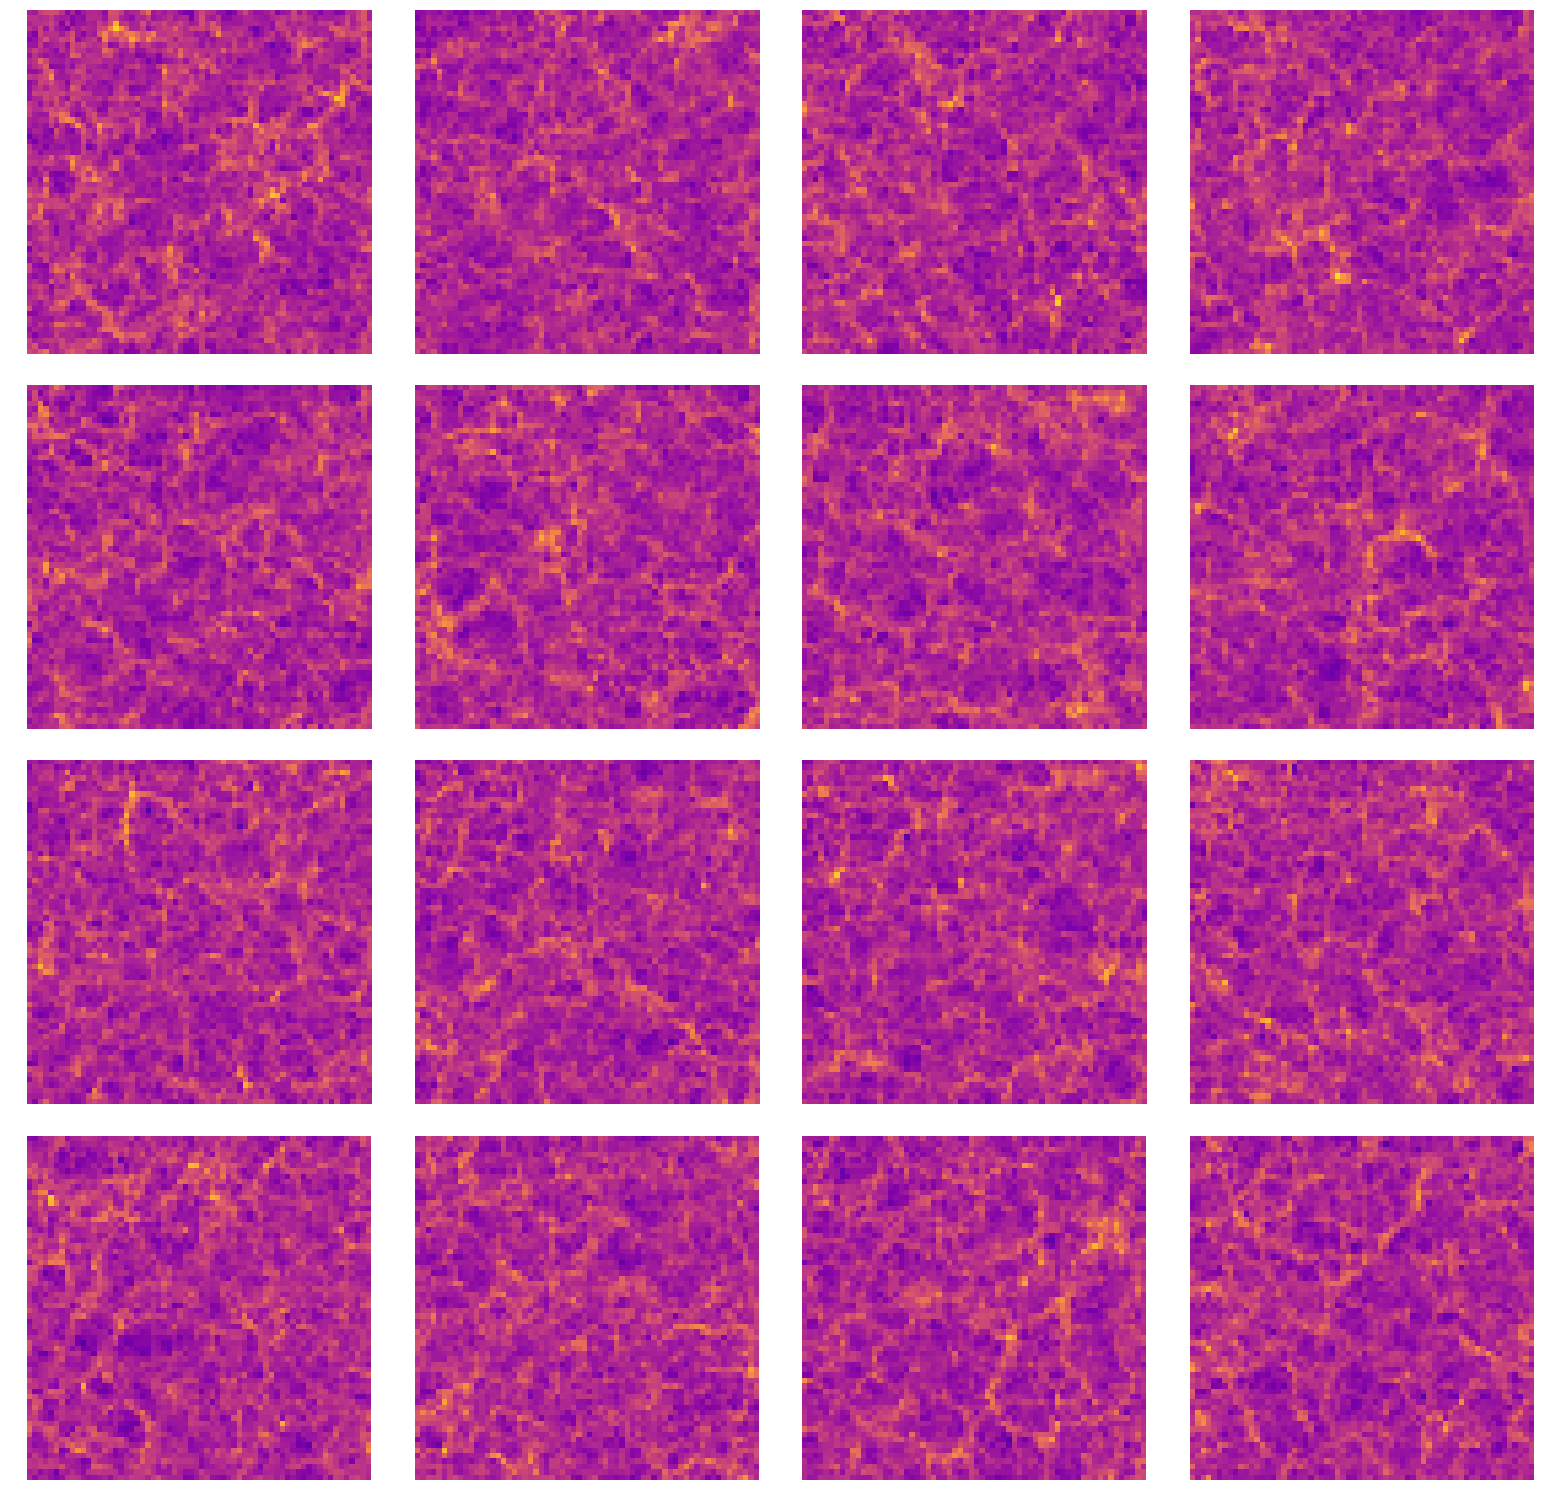

In [14]:
cmin = 0
cmax = 2.5
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_64, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);


## 64->256

In [15]:
gen_samples_64 = utils.load_hdf5(os.path.join(pathsample,'stat-32_64/64_samples_ckpt_latest.h5'))

print('gen_samples_64 shape=', gen_samples_64.shape)
gen_samples_64 = np.expand_dims(gen_samples_64, axis=4)[:num_samples]
print('downsampled shape=', gen_samples_64.shape)

gen_samples_64 shape= (30, 64, 64, 64)
downsampled shape= (30, 64, 64, 64, 1)


In [56]:
name = 'WGAN_stat-64_to_256_checkpoints'
checkpoint256 = 102000 #97000 #51000 #79000 
pathmodel256 = os.path.join(pathmodel, name)

params_256 = utils.load_params(pathmodel256)
# params_256['net']['generator']['use_old_gen'] = True
# params_256 = old2new_params(params_256_old, CosmoUpscalePatchWGAN, checky=True)
# params_256['net']['cosmology']['backward_map'] = backward
# params_256['net']['cosmology']['forward_map'] = forward
# params_256['save_dir'] = pathmodel256

In [57]:
wgan_256 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_256)
gen_samples_256 = wgan_256.upscale_image(small=gen_samples_64, checkpoint=checkpoint256)

Using X_down instead of X_smooth
Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 32, 32, 32, 7)
     BORDER: 0 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 16, 64)
     BORDER: 1 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 8, 64)
     BORDER: 2 Conv layer with 16 channels
         BORDER:  Size of the conv variables: (?, 4, 4, 4, 16)
     BORDER:  Size of the conv variables: (?, 1024)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 1280)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 8, 8)
     Contenate with latent variables to (?, 8, 8, 8, 9)
     1 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 16, 1

IndexError: too many indices for array

In [ ]:
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_256, cmap=plt.cm.plasma, clim=clim, nx=2, ny=2);

In [ ]:
os.makedirs(os.path.join(pathsample,'stat-64_256/'), exist_ok=True)
utils.save_hdf5(gen_samples_256, os.path.join(pathsample,'stat-64_256/256_samples_ckpt_latest.h5'))

# Uniscale model
This is not working. There is a special branch for this model.

In [20]:
name = name = 'WGAN_stat-uniscale_checkpoints'
checkpointuniscale = 109000 #86000

pathmodel_uniscale = os.path.join(pathmodel, name)
params_uniscale = utils.load_params(pathmodel_uniscale)
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
params_uniscale['upscaling']=None
# params_uniscale = old2new_params(params_uniscale_old, CosmoUpscalePatchWGAN, checky=True)

# params_uniscale['net']['cosmology']['backward_map'] = backward_uniscale
# params_uniscale['net']['cosmology']['forward_map'] = forward_uniscale

# params_uniscale['save_dir'] = pathmodel_uniscale
# params_uniscale['net']['generator']['residual'] = False
# params_uniscale['net']['generator']['use_conv_over_deconv'] = False


In [21]:
wgan_uniscale = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_uniscale)
gen_samples_uniscale = wgan_uniscale.upscale_image(N=num_samples, resolution=256, checkpoint=checkpointuniscale)

Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 32, 32, 32, 7)
     BORDER: 0 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 16, 64)
     BORDER: 1 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 8, 64)
     BORDER: 2 Conv layer with 16 channels
         BORDER:  Size of the conv variables: (?, 4, 4, 4, 16)
     BORDER:  Size of the conv variables: (?, 1024)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 1280)
     0 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 16, 16, 16, 8)
     1 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 16, 64)
     2 Deconv layer with 128 channels
         Non linearity applied
     

Current patch: column=1, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=4, height=1

Sampling z
Not loading

Current patch: column=3, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=6, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=7, row=1, height=3

Sampling z
Not loading

Current patch: column=5, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=2, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=7, height=4

Sampling z
Not loading

Current patch: column=7, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=4, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=6

Sampling z
Not loading

Current patch: column=1, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=5, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=6, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=8

Sampling z
Not loading

In [22]:
os.makedirs(os.path.join(pathsample,'stat-uniscale/'), exist_ok=True)
utils.save_hdf5(gen_samples_uniscale, os.path.join(pathsample,'stat-uniscale/256_samples_ckpt_latest.h5'))

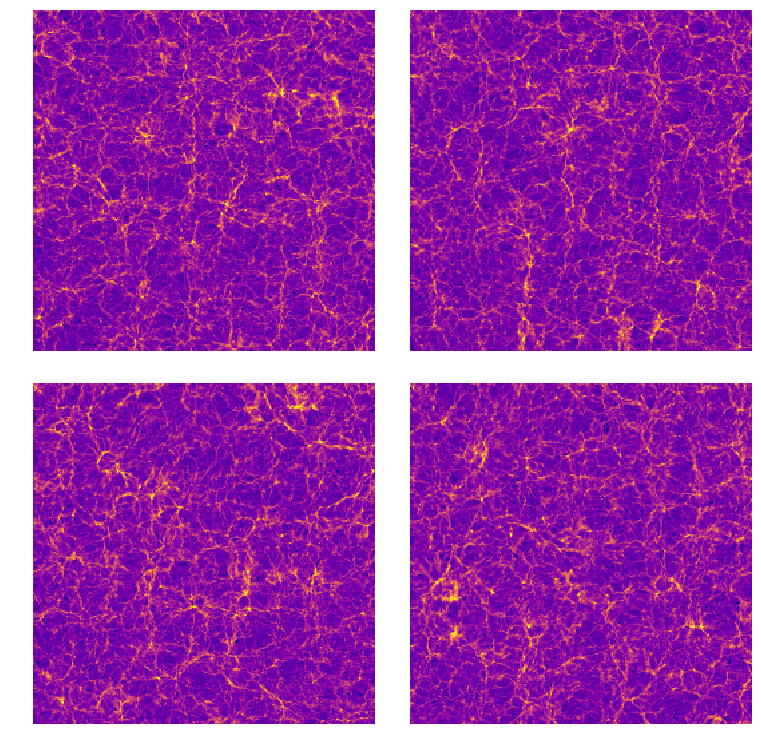

In [23]:
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
plot_cubes_paper(gen_samples_uniscale, cmap=plt.cm.plasma, clim=clim, nx=2, ny=2);

# Make the figures for the paper

In [24]:
pathfig = 'figures/'
os.makedirs(pathfig, exist_ok=True)

#### Load all samples

In [58]:
gen_samples_32 = utils.load_hdf5(os.path.join(pathsample,'stat-0_32/32_samples_ckpt_latest.h5'))
gen_samples_64 = utils.load_hdf5(os.path.join(pathsample,'stat-32_64/64_samples_ckpt_latest.h5'))
gen_samples_256 = utils.load_hdf5(os.path.join(pathsample,'stat-64_256/256_samples_ckpt_latest.h5'))
gen_samples_uniscale = utils.load_hdf5(os.path.join(pathsample,'stat-uniscale/256_samples_ckpt_latest.h5'))


#### Backward transform

In [59]:
gen_samples_32_raw = backward(gen_samples_32)
gen_samples_64_raw = backward(gen_samples_64)
gen_samples_256_raw = backward(gen_samples_256)


In [27]:
gen_samples_uniscale_raw = backward(gen_samples_uniscale)


#### Load real data

In [28]:
dataset256 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=256,patch=False,is_3d=True,augmentation=False)
real_samples_256 = dataset256.get_all_data()
del dataset256


images shape =  (30, 256, 256, 256)


In [29]:
real_samples_256_raw = backward(real_samples_256)

In [30]:
dataset32 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=32,patch=False,is_3d=True,augmentation=False, scaling=8)
real_samples_32 = dataset32.get_all_data()
del dataset32

images shape =  (30, 256, 256, 256)


In [31]:
real_samples_32_raw = backward(real_samples_32)

In [32]:
dataset64 = data.load.load_nbody_dataset(resolution=256,Mpch=350,shuffle=False,forward_map=forward,spix=64,patch=False,is_3d=True,augmentation=False, scaling=4)
real_samples_64 = dataset64.get_all_data()
del dataset64

images shape =  (30, 256, 256, 256)


In [33]:
real_samples_64_raw = backward(real_samples_64)

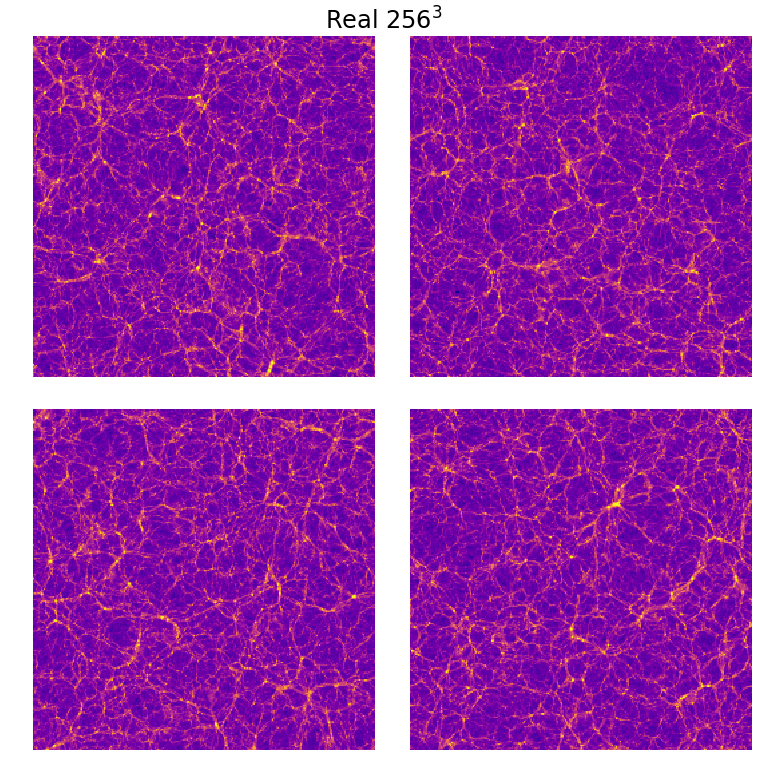

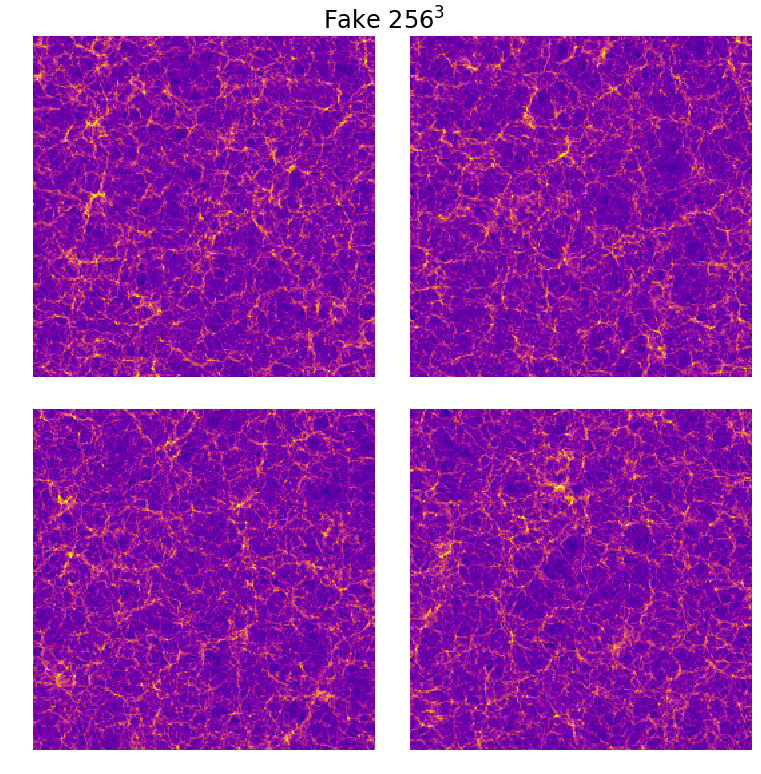

In [60]:
# cmin = np.min(cubes)
# cmax = np.max(cubes)/1.5
cmin = 0
cmax = 3.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"real256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_256, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"fake256.pdf", bbox_inches='tight', format='pdf')



Log l2 Mass histogram loss: 0.6110828485253796
L2 Peak Mass histogram: 8.472271365396133e-05
Log l1 Mass histogram loss: 0.3808318490991419
L1 Mass histogram loss: 0.004813709855079652


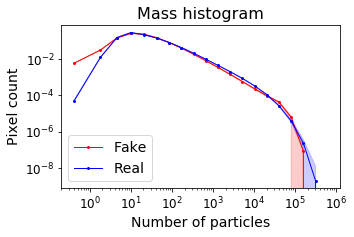

In [61]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 0.6593998521234832
L2 Peak Count loss: 0.00023284152168412522
Log l1 Peak Count loss: 0.6218742752309214
L1 Peak Count loss: 0.010591567020087855


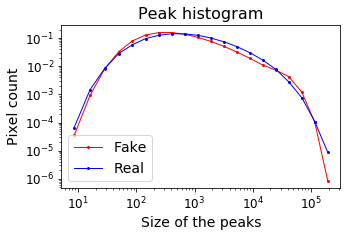

In [62]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.8527063834052682
L2 PSD loss: 10428.82910625411
Log l1 PSD loss: 0.7799139126988784
L1 PSD loss: 41.04231498949214


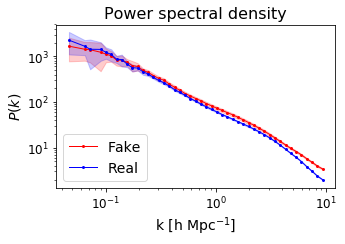

In [63]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_256_raw)
plt.savefig(pathfig+"256full_psd.pdf", bbox_inches='tight', format='pdf')

# Scale by scale analysis

## 32 cubes

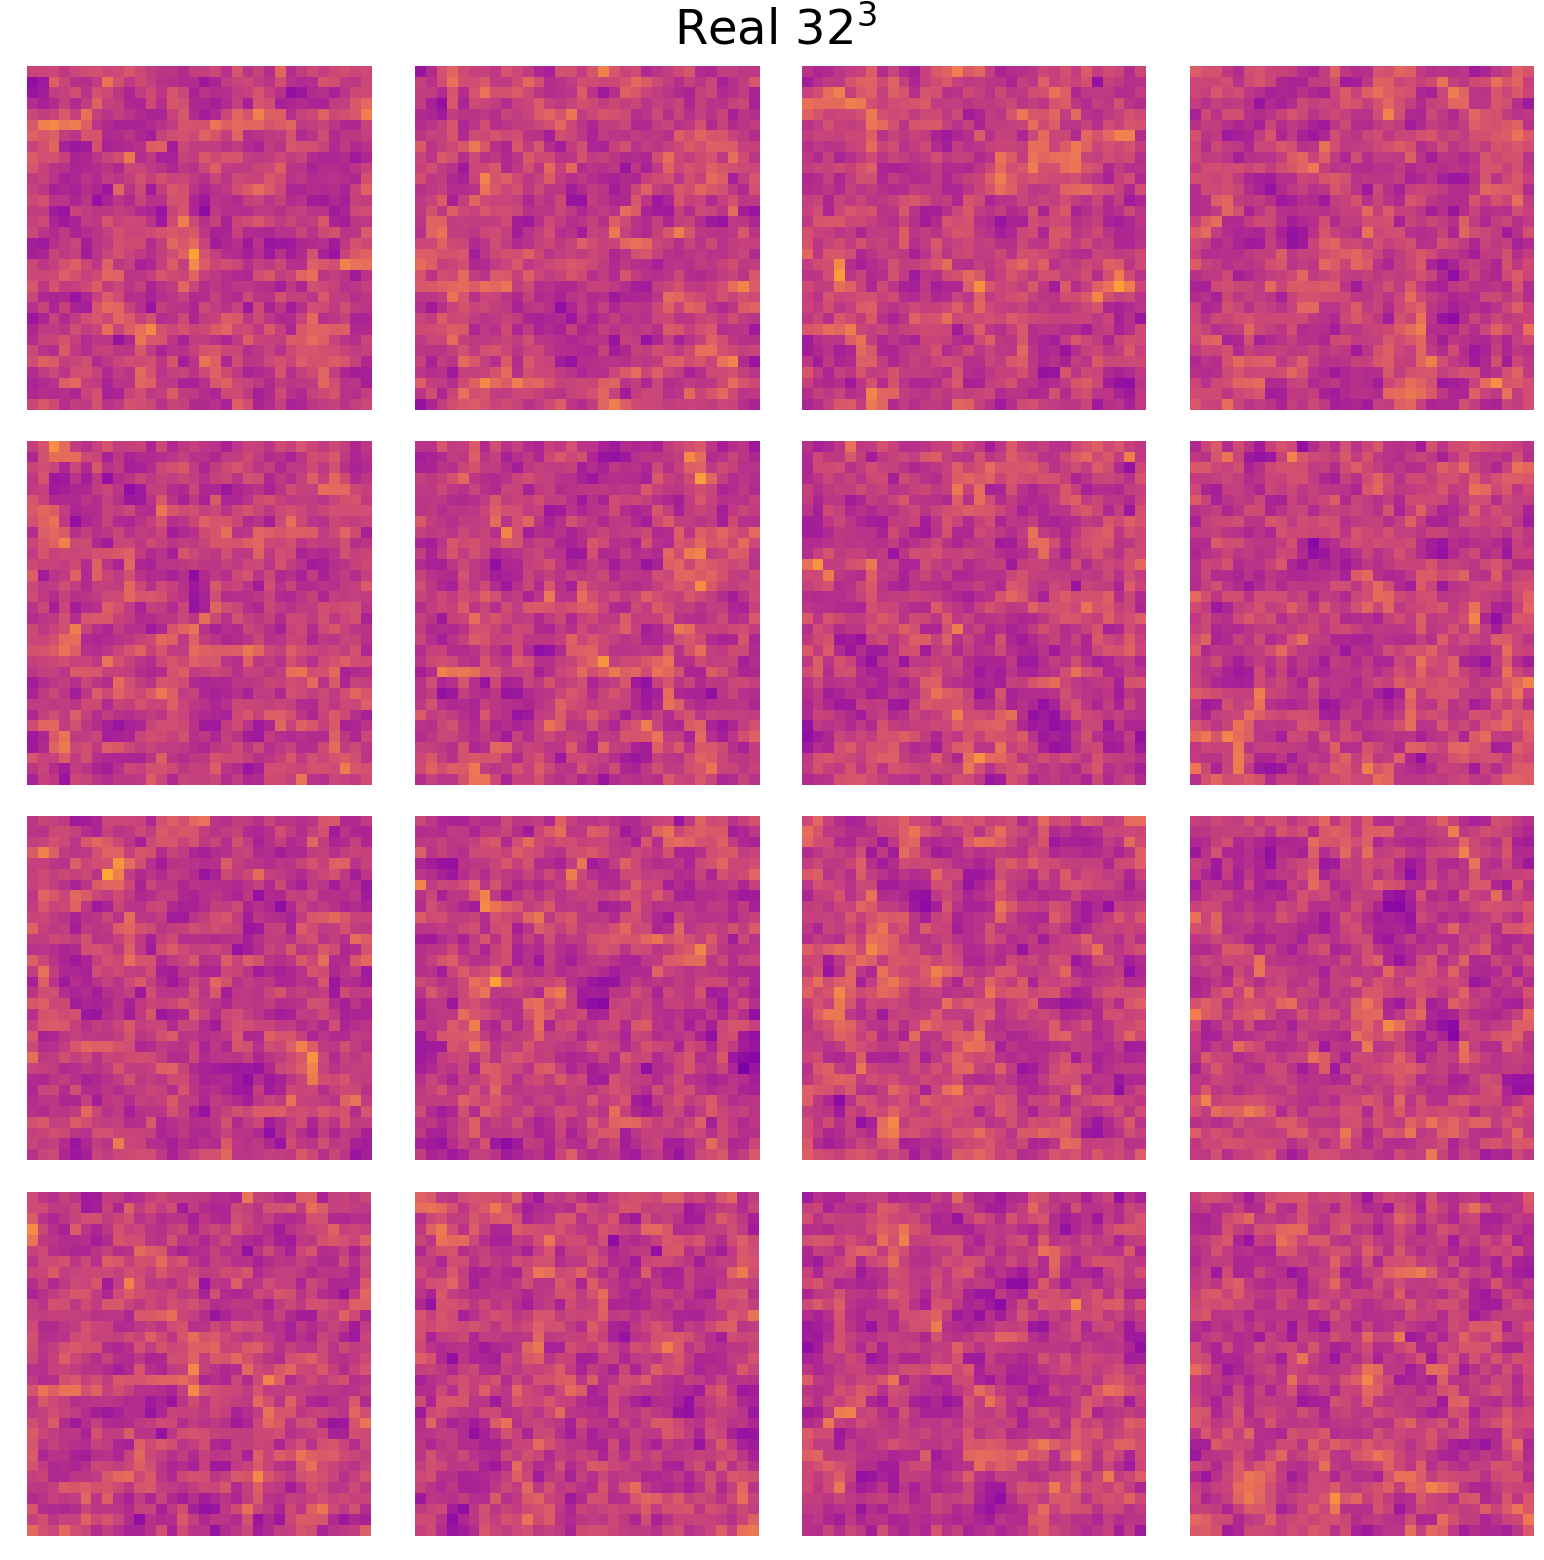

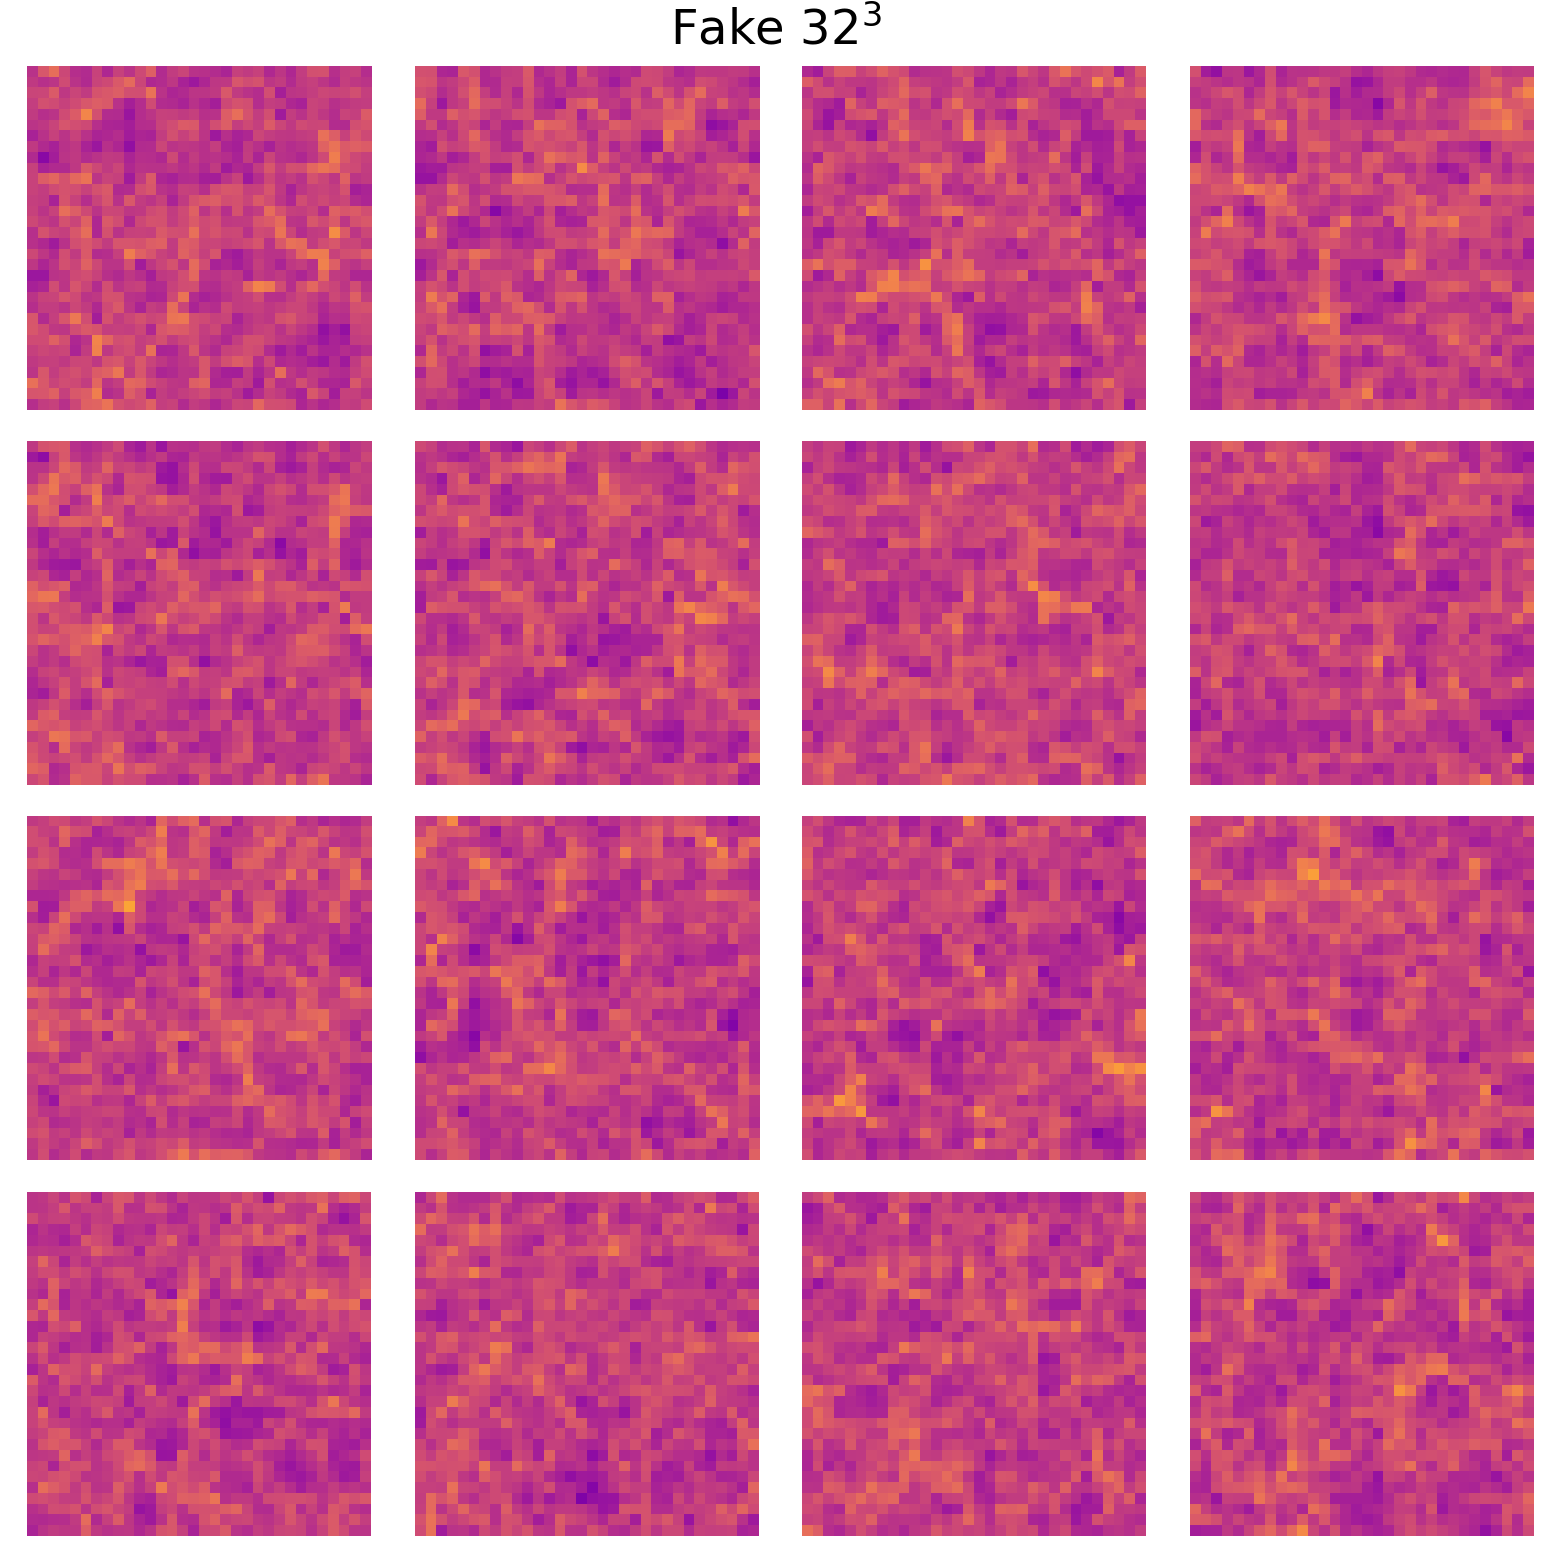

In [38]:
# cmin = np.min(cubes_32)
# # cmin = 0
# cmax = np.max(cubes_32)
cmin = 0.1
cmax = 2
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);
fig.suptitle('Real $32^3$', y=1.03, fontsize=48 )
plt.savefig(pathfig+"real32.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_32, cmap=plt.cm.plasma, clim=clim, nx=4, ny=4);
fig2.suptitle('Fake $32^3$', y=1.03, fontsize=48 )
plt.savefig(pathfig+"fake32.pdf", bbox_inches='tight', format='pdf')



Log l2 Mass histogram loss: 0.01124706838066375
L2 Peak Mass histogram: 3.3074684648050223e-06
Log l1 Mass histogram loss: 0.06923473337655206
L1 Mass histogram loss: 0.0010538736979166668


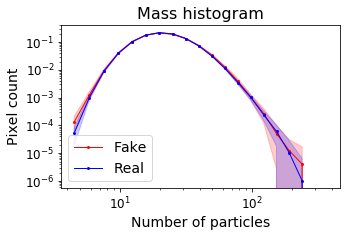

In [39]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 0.059522571837767733
L2 Peak Count loss: 1.7068755483044762e-05
Log l1 Peak Count loss: 0.20498105194637645
L1 Peak Count loss: 0.0028034990573637926


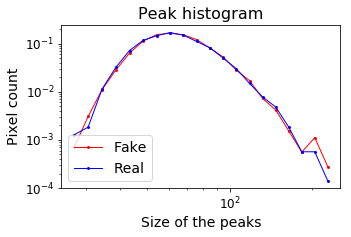

In [40]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.10049905280237212
L2 PSD loss: 304.60686535519983
Log l1 PSD loss: 0.24548739614515364
L1 PSD loss: 7.435510915670074


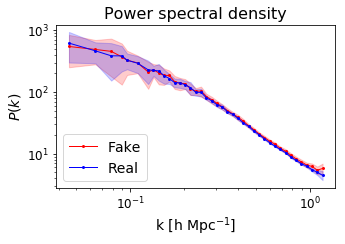

In [41]:
evaluation.compute_and_plot_psd(real_samples_32_raw, gen_samples_32_raw)
plt.savefig(pathfig+"32_psd.pdf", bbox_inches='tight', format='pdf')

## 64 Cubes

In [42]:
name = 'WGAN_stat-32_to_64_checkpoints'
class CosmoUpscalePatchWGAN(UpscalePatchWGAN, CosmoWGAN):
    pass
pathmodel64 = os.path.join(pathmodel, name)
params_64 = utils.load_params(pathmodel64)
wgan_64 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_64)
gen_samples_64_single = wgan_64.upscale_image(small=np.reshape(real_samples_32, [*real_samples_32.shape,1]), checkpoint=checkpoint64)

Using X_down instead of X_smooth
Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 32, 32, 32, 7)
     BORDER: 0 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 16, 64)
     BORDER: 1 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 8, 64)
     BORDER: 2 Conv layer with 16 channels
         BORDER:  Size of the conv variables: (?, 4, 4, 4, 16)
     BORDER:  Size of the conv variables: (?, 1024)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 1280)
     0 Full layer with 16384 outputs
         Size of the variables: (?, 16384)
     Reshape to (?, 16, 16, 16, 4)
     Contenate with latent variables to (?, 16, 16, 16, 5)
     1 Deconv layer with 64 channels
         Non linearity applied
         Size of the variables: (?

In [43]:
gen_samples_64_single_raw = backward(gen_samples_64_single)

[autoreload of gantools.metric.stats failed: Traceback (most recent call last):
  File "/users/nperraud/upgan/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/users/nperraud/upgan/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 374, in superreload
    module = reload(module)
  File "/users/nperraud/upgan/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/users/nperraud/upgan/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/scratch/snx3000/

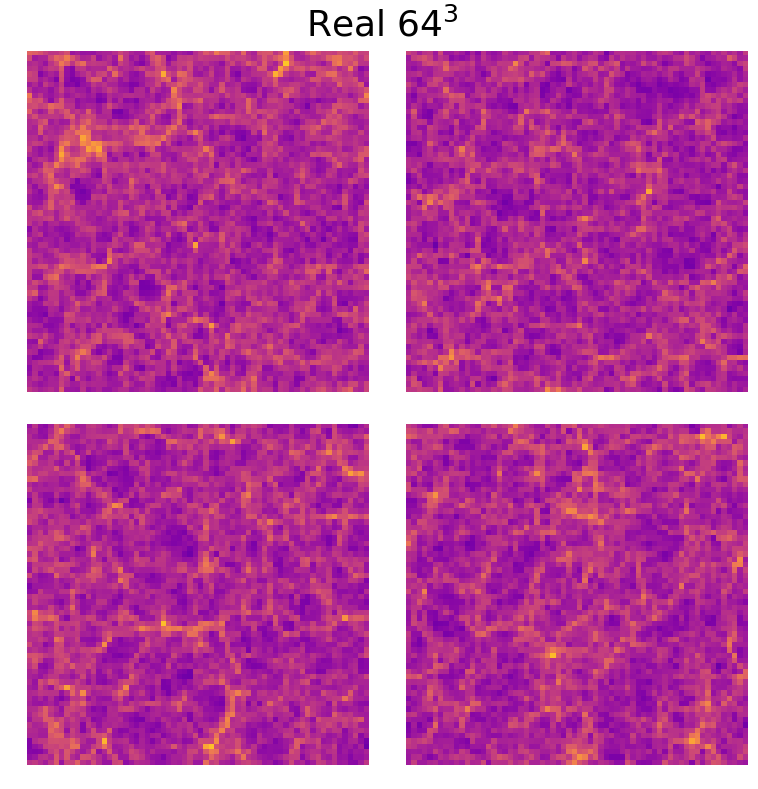

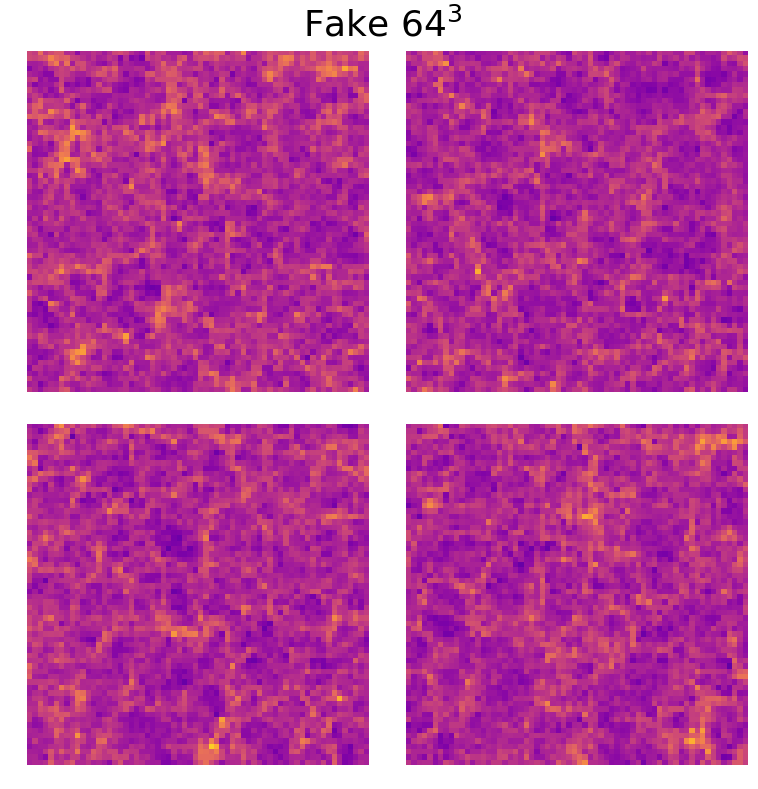

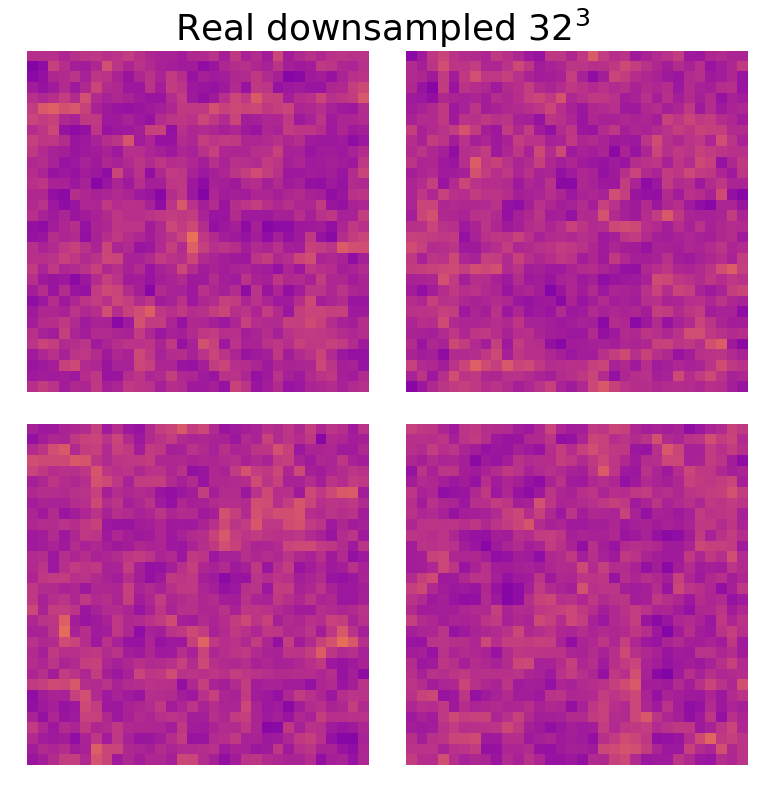

In [44]:
# cmin = np.min(cubes_64)
# cmax = np.max(cubes_64)
cmin = 0
cmax = 2.5
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_64, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $64^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_real64.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_64_single, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $64^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_fake64.pdf", bbox_inches='tight', format='pdf')

fig = plot_cubes_paper(real_samples_32, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real downsampled $32^3$', y=1.04, fontsize=36 )
plt.savefig(pathfig+"up_down32.pdf", bbox_inches='tight', format='pdf')

Log l2 Mass histogram loss: 0.05152793270952646
L2 Peak Mass histogram: 1.8482804671900045e-05
Log l1 Mass histogram loss: 0.12378123177091482
L1 Mass histogram loss: 0.0021305974324544287


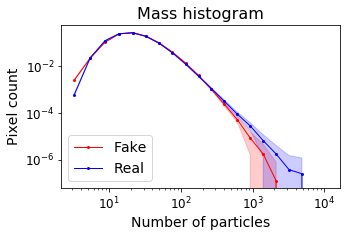

In [45]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 0.22897346895235052
L2 Peak Count loss: 8.055124754889652e-05
Log l1 Peak Count loss: 0.3764384222975934
L1 Peak Count loss: 0.005540164362942427


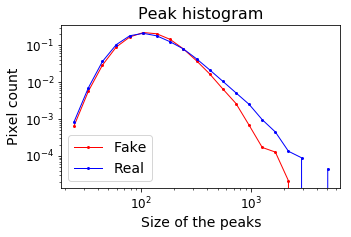

In [46]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.9641901845555829
L2 PSD loss: 3141.743523688337
Log l1 PSD loss: 0.662930382395929
L1 PSD loss: 21.696247325453808


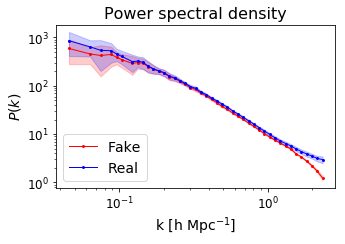

In [47]:
evaluation.compute_and_plot_psd(real_samples_64_raw, gen_samples_64_single_raw)
plt.savefig(pathfig+"up_64_psd.pdf", bbox_inches='tight', format='pdf')

## 256 Cubes

In [64]:
name = 'WGAN_stat-64_to_256_checkpoints'
pathmodel256 = os.path.join(pathmodel, name)

params_256 = utils.load_params(pathmodel256)

wgan_256 = UpcaleGANsystem(CosmoUpscalePatchWGAN, params_256)
gen_samples_single_256 = wgan_256.upscale_image(small=np.reshape(real_samples_64, [*real_samples_64.shape, 1]), checkpoint=checkpoint256)

Using X_down instead of X_smooth
Border block

--------------------------------------------------
     BORDER:  The input is of size (?, 32, 32, 32, 7)
     BORDER: 0 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 16, 16, 16, 64)
     BORDER: 1 Conv layer with 64 channels
         BORDER:  Size of the conv variables: (?, 8, 8, 8, 64)
     BORDER: 2 Conv layer with 16 channels
         BORDER:  Size of the conv variables: (?, 4, 4, 4, 16)
     BORDER:  Size of the conv variables: (?, 1024)
--------------------------------------------------

Generator 
--------------------------------------------------
     The input is of size (?, 256)
     Contenate with latent variables to (?, 1280)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 8, 8)
     Contenate with latent variables to (?, 8, 8, 8, 9)
     1 Deconv layer with 256 channels
         Non linearity applied
         Size of the variables: (?, 16, 1

Current patch: column=7, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=2, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=4, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=1

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=2, row=4, height=1

Sampling z
Not loading a checkpoint
Current patch: column=3, row=4, height=1

Sampling z
Not loading

Current patch: column=1, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=2, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=3, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=4, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=5, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=6, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=2

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=4, row=1, height=3

Sampling z
Not loading a checkpoint
Current patch: column=5, row=1, height=3

Sampling z
Not loading

Current patch: column=3, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=8, row=5, height=4

Sampling z
Not loading a checkpoint
Current patch: column=1, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=2, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=3, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=4, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=5, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=6, row=6, height=4

Sampling z
Not loading a checkpoint
Current patch: column=7, row=6, height=4

Sampling z
Not loading

Current patch: column=5, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=2, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=2, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=3, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=4, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=5, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=6, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=7, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=8, row=3, height=6

Sampling z
Not loading a checkpoint
Current patch: column=1, row=4, height=6

Sampling z
Not loading

Current patch: column=7, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=7, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=2, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=3, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=4, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=5, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=6, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=7, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=8, row=8, height=7

Sampling z
Not loading a checkpoint
Current patch: column=1, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=2, row=1, height=8

Sampling z
Not loading a checkpoint
Current patch: column=3, row=1, height=8

Sampling z
Not loading

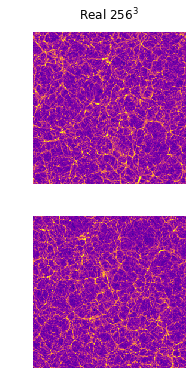

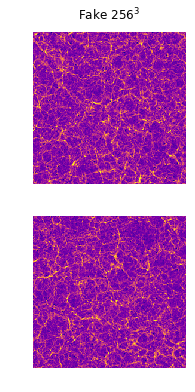

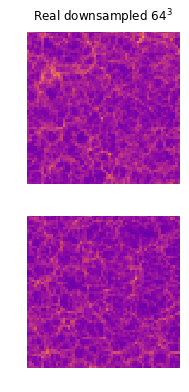

In [65]:
# cmin = np.min(cubes_256)
# cmax = np.max(cubes_256)/2.5
cmin = 0
cmax = 3
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim, ny=1);
fig.suptitle('Real $256^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_real256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_single_256, cmap=plt.cm.plasma, clim=clim, ny=1);
fig2.suptitle('Fake $256^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_fake256.pdf", bbox_inches='tight', format='pdf')

fig = plot_cubes_paper(real_samples_64, cmap=plt.cm.plasma, clim=clim, ny=1);
fig.suptitle('Real downsampled $64^3$', y=1.03, fontsize=12 )
plt.savefig(pathfig+"up_down64.pdf", bbox_inches='tight', format='pdf')

In [66]:
gen_samples_single_256_raw = backward(gen_samples_single_256)

Log l2 Mass histogram loss: 0.4911396727118166
L2 Peak Mass histogram: 5.007393556465287e-05
Log l1 Mass histogram loss: 0.3632680295495845
L1 Mass histogram loss: 0.003933344682057699


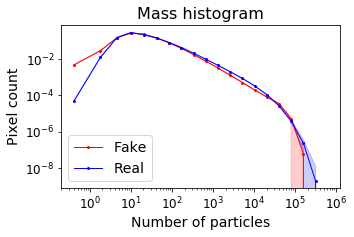

In [67]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 0.847415899373565
L2 Peak Count loss: 0.0002422322475808298
Log l1 Peak Count loss: 0.7115350663716121
L1 Peak Count loss: 0.011203172993020554


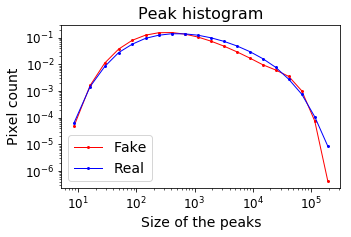

In [68]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 0.6624704306845617
L2 PSD loss: 5550.82273283934
Log l1 PSD loss: 0.7191484136126766
L1 PSD loss: 40.54836285818668


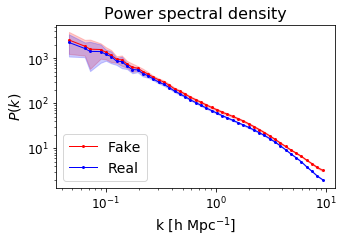

In [69]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_single_256_raw)
plt.savefig(pathfig+"up_256_psd.pdf", bbox_inches='tight', format='pdf')

## Uniscale

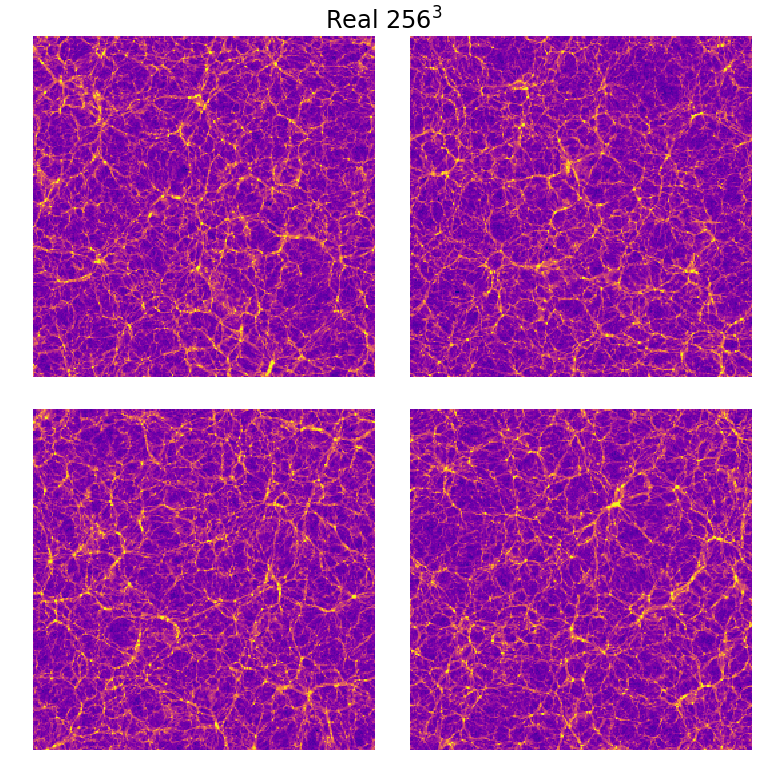

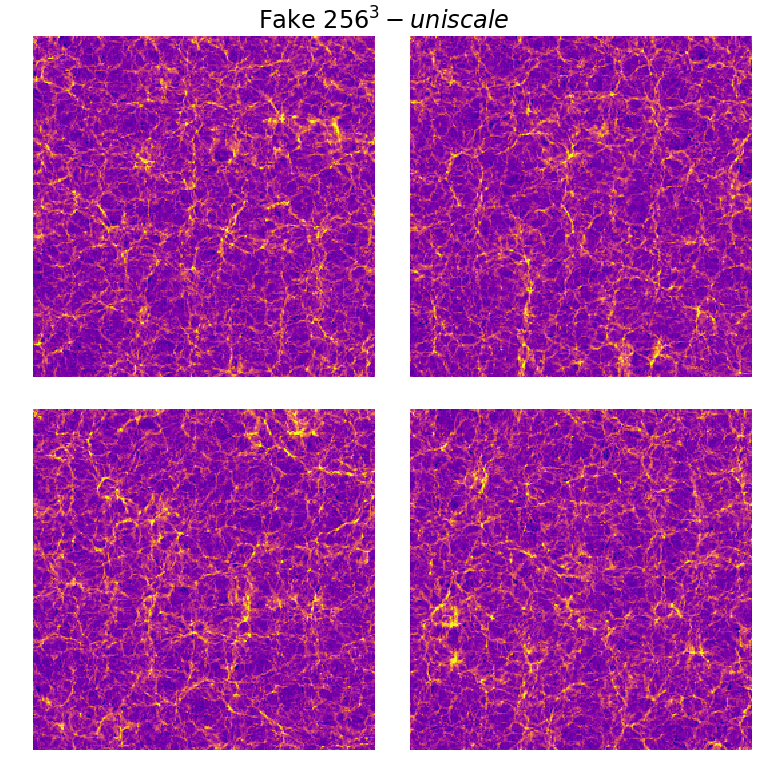

In [54]:
cmin = 0
cmax = 3
clim = (cmin, cmax)
fig = plot_cubes_paper(real_samples_256, cmap=plt.cm.plasma, clim=clim);
fig.suptitle('Real $256^3$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"uniscalereal256.pdf", bbox_inches='tight', format='pdf')

fig2 = plot_cubes_paper(gen_samples_uniscale, cmap=plt.cm.plasma, clim=clim);
fig2.suptitle('Fake $256^3 - uniscale$', y=1.02, fontsize=24 )
plt.savefig(pathfig+"uniscalefake256.pdf", bbox_inches='tight', format='pdf')

Log l2 Mass histogram loss: 0.5207379038270166
L2 Peak Mass histogram: 0.00011360657180990372
Log l1 Mass histogram loss: 0.40742470112636264
L1 Mass histogram loss: 0.005940765341122945


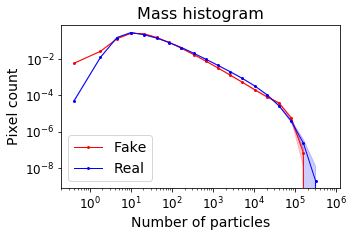

In [70]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_hist.pdf", bbox_inches='tight', format='pdf')

Log l2 Peak Count loss: 0.8165142409353532
L2 Peak Count loss: 0.00025497476647861337
Log l1 Peak Count loss: 0.6975420770056919
L1 Peak Count loss: 0.011344317734788946


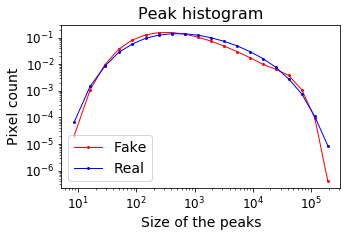

In [71]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_peak.pdf", bbox_inches='tight', format='pdf')

Log l2 PSD loss: 1.1332090941409778
L2 PSD loss: 49620.86806772866
Log l1 PSD loss: 0.7614670913817033
L1 PSD loss: 80.97970821285253


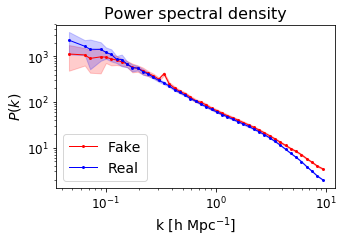

In [72]:
evaluation.compute_and_plot_psd(real_samples_256_raw, gen_samples_uniscale_raw)
plt.savefig(pathfig+"256uniscale_psd.pdf", bbox_inches='tight', format='pdf')

# Gifs

## Real 256 cubes

In [ ]:
# fps=16
# clim = (0,3)
# plot.animate_cubes(real_samples_256, output_name=pathfig+"real256.gif", clim=clim, fps=fps, cmap=plt.cm.plasma)
# animation = plot.cubes_to_animation(real_samples_256, cmap=plt.cm.plasma, clim=clim)
# animation.ipython_display(fps=16, loop=True, autoplay=True)


In [ ]:
plot.save_animation(real_samples_256[0], gen_samples_256[0], figsize=(10, 6), fps=16, format='mp4', output_file_name=pathfig+'final.mp4', clim=clim)
# plt.style.use('ggplot')

In [ ]:
x = np.random.randn(10,3,4,5)

In [ ]:
a,b = np.histogram(x)
x.size